In [2]:
import pymc as pm
import pytensor.tensor as pyt
import numpy as np
import matplotlib.pyplot as plt
from ElectionForecasting.src.modelling.DataLoader import DataLoader
from ElectionForecasting.src.modelling.DatalandElectionModel import (
    add_coordinates, add_data,
    get_lagged_mu_contribution,
    linear_combination_of_vote_share,
    proportion
)
from ElectionForecasting.src.utils.backtesting_utilities import initialize_driver_and_data

In [3]:
data_loader = DataLoader()
y = '2022'
driver = initialize_driver_and_data(y, data_loader)
(gam_forecasts_df, train_df, vote_shares, previous_year_pleans) = (
    driver.gam_forecast, driver.train, driver.state_train, driver.previous_year_pleans
)

INFO:root:Initializing Driver object.
INFO:root:Loading pleans.
INFO:root:Loading state results.
INFO:root:Loading model inputs.
INFO:root:Loading GAM forecasts.
INFO:root:Loading pleans correlations.
INFO:root:Setting random seed to 123.
INFO:root:Building build_modelthe model.
INFO:root:Transforming input data.
INFO:root:Retrieving GAM forecast for 2022.
INFO:root:Performing categorical transformations.
INFO:root:Performing categorical transformations.


In [8]:
def linear_combination_of_vote_share(
        t, n_time_points, gam_forecasts, observed_vote_share,
        switchpoint_min, switchpoint_max
    ):
    switchpoint_diff = switchpoint_max - switchpoint_min
    # change the bounds of the linear function
    norm_t = alpha_switch_min + switchpoint_diff * (t/n_time_points)
    a = gam_forecasts* norm_t[:, None, None] # gam_forecasts * norm_t[None,:,None]
    b = observed_vote_share[None,:] * (1-norm_t)[:,None, None]
    daily_obs_vote_share_state_wise = a+b
    return daily_obs_vote_share_state_wise

with pm.Model(coords={'all_days_till_the_election': gam_forecasts_df.index[::-1]}) as model:
    ### Welcome to the world of probabilistic programming.
    ### please leave your coats, shoes, and singularly defined
    ### variables at the door.

    # Prepare the PyMC model context
    add_coordinates(model, train_df, gam_forecasts_df)
    add_data(
        gam_forecasts_df.iloc[:,:4].values,
        vote_shares,
        previous_year_pleans
    )
    # A binary mask to distinguish between parties that do and do not contest in each province
    does_compete = model['does_compete']

    # Time for change section of the model
    alpha_prior_mean = np.full((4, ), .25)
    sigma_prior_mean = np.full((4, ), .25)
    alphas = pm.Normal('alphas', mu=alpha_prior_mean,  sigma=sigma_prior_mean)
    lagged_contributions = get_lagged_mu_contribution(train_df, lag=3)
    mus = pm.Deterministic('mus', pm.math.exp(alphas + lagged_contributions))
    dirichlet_alphas = pm.Deterministic('dirichlet_alphas', mus)

    # Fundamentals based national vote share prediction
    observed_vote_share = pm.Dirichlet('observed_vote_share', a=dirichlet_alphas, observed=model['y_data']) 

    # Combination of fundamentals based prediction with polling data
    poll_forecasts = model['gam_forecasts']
    time_for_change_prior = observed_vote_share[-1, None, :]
    n_days_of_polling = model.dim_lengths['polling_date']
    n_time_points = model.dim_lengths['all_days_till_the_election']
    t = pyt.arange(1, n_time_points + 1)
    t = t[-n_days_of_polling:]
    # Define the max and min for alpha switching
    # These can be replaced by RVs for a more Bayesian approach
    alpha_switch_max = 0.85
    alpha_switch_min = 0.35

    # I weight the parties national vote share since the SSP's nationally
    # observed polling results should be proportionally increased in the
    # states in which they do compete. This is a flawed assumption, and 
    # warrants more attention.
    does_compete_national = does_compete.mean(axis=0)
    poll_forecasts_state_wise = (
            poll_forecasts[:, None, :] *
            (does_compete_national*does_compete)[None, :]
    )

    # using a linear function to combine these predictors. Can adapt to
    # more complex functions.
    daily_obs_vote_share_state_wise = pm.Deterministic(
        'daily_obs_vote_share',
            linear_combination_of_vote_share(
                t, n_time_points, poll_forecasts_state_wise,
                time_for_change_prior,
                switchpoint_min=alpha_switch_min,
                switchpoint_max=alpha_switch_max
        )
    )

    # The state specific vote shares is then taken as the sum of the previous
    # year's partisan leans and the observed national vote share projections.
    # Incorporating the covariance martix into this calculation induced significant
    # model instability, and adversely affected model results, so was omitted, however
    # this is worth more attention.
    partisan_leans = model['previous_year_pleans'] 
    pm.Deterministic('state_vote_share', 
                        proportion(
                                daily_obs_vote_share_state_wise +
                                (
                                    partisan_leans[None, :, :] *
                                    does_compete[None, :, :]
                                )
                            )*does_compete[None, :, :])
    trace = pm.sample()

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, alpha_party_lag_3q, alpha_pop_vote_lag_3q, betas_gdp_lag_3q, betas_inflation_lag_3q, betas_stk_mkt_lag_3q, betas_unemployment_lag_3q]
INFO:pymc.sampling.mcmc:NUTS: [alphas, alpha_party_lag_3q, alpha_pop_vote_lag_3q, betas_gdp_lag_3q, betas_inflation_lag_3q, betas_stk_mkt_lag_3q, betas_unemployment_lag_3q]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


INFO:root:Initializing Driver object.
INFO:root:Loading pleans.
INFO:root:Loading state results.
INFO:root:Loading model inputs.
INFO:root:Loading GAM forecasts.
INFO:root:Loading pleans correlations.
INFO:root:Setting random seed to 123.
INFO:root:Building build_modelthe model.
INFO:root:Transforming input data.
INFO:root:Retrieving GAM forecast for 2022.
INFO:root:Performing categorical transformations.
INFO:root:Performing categorical transformations.
INFO:root:Fitting the model.
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas, alpha_party_lag_3q, alpha_pop_vote_lag_3q, betas_gdp_lag_3q, betas_inflation_lag_3q, betas_stk_mkt_lag_3q, betas_unemployment_lag_3q]
INFO:pymc.sampling.mcmc:NUTS: [alphas, alpha_party_la

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:root:Running prediction step.
INFO:root:Getting Bayesian update data.
INFO:root:Retrieving GAM forecast for 2022.
INFO:root:Predictive sampling for all regions
Sampling: [observed_vote_share, party_effect_lag_3q, pop_vote_lag_3q]
INFO:pymc.sampling.forward:Sampling: [observed_vote_share, party_effect_lag_3q, pop_vote_lag_3q]


NameError: name 'plt' is not defined

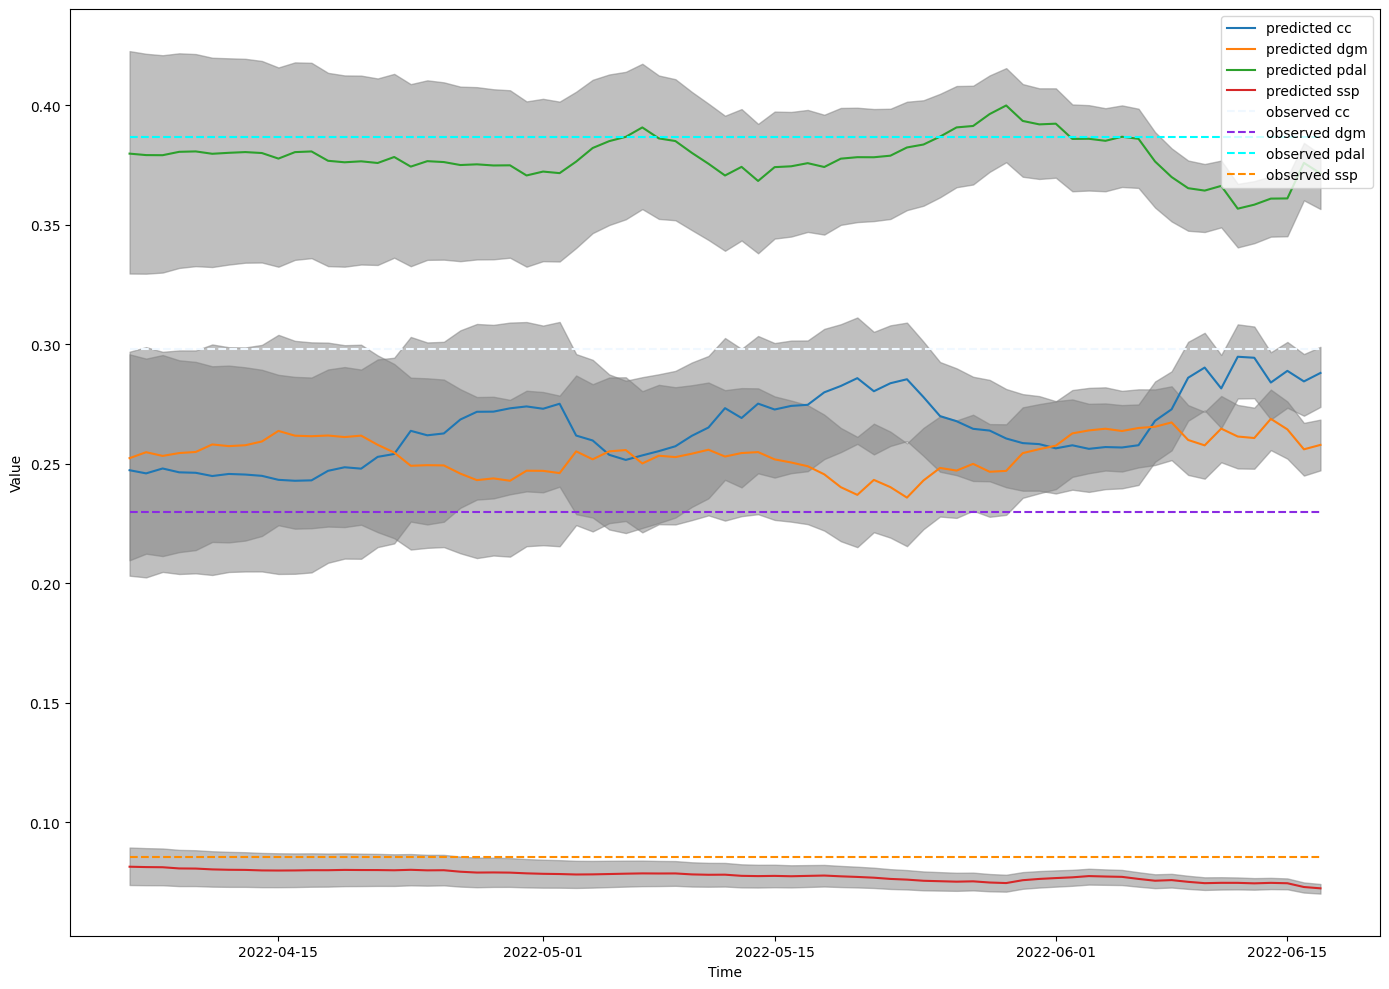

In [9]:
from ElectionForecasting.src.utils.backtesting_utilities import (
    initialize_driver_and_data, fit_and_predict
)
import pandas as pd
from ElectionForecasting.src.config import party_order, province_order
from ElectionForecasting.src.utils.plotting_utils import plot_prob_band

# Initialize driver and data
driver = initialize_driver_and_data(y, data_loader)
driver.model = model
driver.trace = trace
# Fit and predict
predictive_samples = fit_and_predict(driver)
predictive_samples = predictive_samples.posterior_predictive.\
    state_vote_share.values
predictive_samples = predictive_samples.reshape(
    ([-1] + list(predictive_samples.shape[-3:]))
)
posterior_samples = predictive_samples.mean(axis=2)
observations = pd.DataFrame(
    [driver.state_test[0].mean(axis=0)], columns=party_order
).T
plot_prob_band(
    predictions=posterior_samples, observed=observations,
    time_index=pd.to_datetime(
        driver.updated_poll_data.index)[::-1]
)
plt.show()